In [1]:
# get some real data
import mne
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import neurodsp
import neurodsp.sim
import neurodsp.spectral
import fooof
import fractions
import scipy.signal

## MNE data

In [ ]:
example_data_path = Path(r"F:\sleep EDF files\LDEEG\data\raw")
example_data_file = example_data_path/os.listdir(example_data_path)[0]
raw = mne.io.read_raw_edf(example_data_file)

In [9]:
raw.pick_channels([ch for ch in raw.ch_names if ch.startswith("EEG ")])
raw.ch_names

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


['EEG F7',
 'EEG T3',
 'EEG T5',
 'EEG Fp1',
 'EEG F3',
 'EEG C3',
 'EEG P3',
 'EEG O1',
 'EEG F8',
 'EEG T4',
 'EEG T6',
 'EEG Fp2',
 'EEG F4',
 'EEG C4',
 'EEG P4',
 'EEG O2',
 'EEG Fz',
 'EEG Cz',
 'EEG Pz',
 'EEG Oz',
 'EEG A1',
 'EEG A2']

In [10]:
raw.load_data()

Reading 0 ... 5615999  =      0.000 ... 28079.995 secs...


<RawEDF | 0_0004401.edf, 22 x 5616000 (28080.0 s), ~942.6 MB, data loaded>

In [11]:
raw.plot()

Using qt as 2D backend.


In [15]:
# animation of FOOOF

np.shape(raw.get_data()[0])

(5616000,)

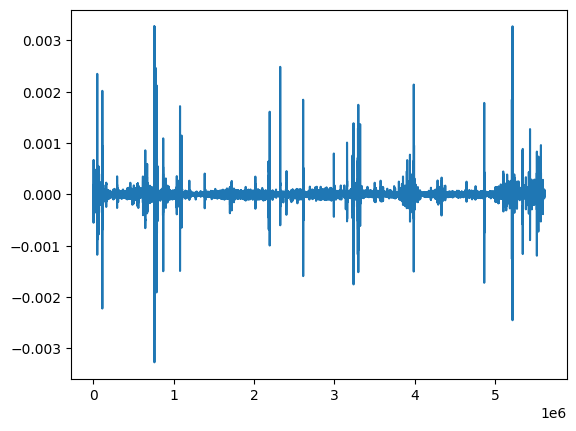

In [17]:
plt.plot(raw.get_data()[0])

## animations

In [2]:
%matplotlib tk

In [3]:
neurodsp.sim.set_random_seed(10)

n_seconds   = 15
fs          = 256

# alpha peak
osc_sig1 = neurodsp.sim.sim_oscillation(n_seconds, fs, freq=10, variance=0.4)
# beta peak
osc_sig2 = neurodsp.sim.sim_oscillation(n_seconds, fs, freq=20, variance=0.25)
# aperiodic component
ap_sig = neurodsp.sim.sim_powerlaw(n_seconds, fs, exponent=-2.5, f_range=[1.5, 75])

sig_comb = ap_sig + osc_sig1 + osc_sig2

freqs, powers = neurodsp.spectral.compute_spectrum(sig_comb, fs)
times = neurodsp.utils.create_times(n_seconds, fs)

f, ax = plt.subplots(2, 1)
neurodsp.plts.plot_time_series(times, sig_comb, ax=ax[0])
neurodsp.plts.plot_time_series(freqs, powers, ax=ax[1])
ax[1].set_xlim([2.5, 50])
plt.show()

### IRASA

In [7]:
# Check & get the resampling factors, with rounding to avoid floating point precision errors
hset = np.arange(1.01, 1.99, 0.01)
hset = np.round(hset, 4)

# The `nperseg` input needs to be set to lock in the size of the FFT's
nperseg = int(4 * fs)

# Calculate the original spectrum across the whole signal
freqs, psd = neurodsp.spectral.compute_spectrum(sig_comb, fs, nperseg=nperseg) #, **spectrum_kwargs)

# Do the IRASA resampling procedure
psds = np.zeros((len(hset), *psd.shape))

def animate(ind):

    for ax in axs: ax.clear()

    h_val = hset[ind]

    # Get the up-sampling / down-sampling (h, 1/h) factors as integers
    rat = fractions.Fraction(str(h_val))
    up, dn = rat.numerator, rat.denominator

    # Resample signal
    sig_up = scipy.signal.resample_poly(sig_comb, up, dn, axis=-1)
    sig_dn = scipy.signal.resample_poly(sig_comb, dn, up, axis=-1)

    # Calculate the power spectrum, using the same params as original
    freqs_up, psd_up = neurodsp.spectral.compute_spectrum(sig_up, h_val * fs, nperseg=nperseg) #, **spectrum_kwargs)
    freqs_dn, psd_dn = neurodsp.spectral.compute_spectrum(sig_dn, fs / h_val, nperseg=nperseg) #, **spectrum_kwargs)

    # Calculate the geometric mean of h and 1/h
    psds[ind, :] = np.sqrt(psd_up * psd_dn)

    # Take the median resampled spectra, as an estimate of the aperiodic component
    psd_aperiodic = np.median(psds[:ind], axis=0)

    # Subtract aperiodic from original, to get the periodic component
    psd_periodic = psd - np.median(psds[:ind], axis=0)

    fig.suptitle(f"current resampling factor:\n{h_val}")
    axs[0].plot(freqs, psd)
    axs[0].plot(freqs, psds[ind])
    axs[0].set_xlim([2.5, 30])
    axs[0].set_ylim([0, 0.7])
    axs[0].text(20, 0.5, "resampled\nPSD", fontsize="xx-large")
    axs[1].plot(freqs, psd_aperiodic)
    axs[1].set_xlim([2.5, 30])
    axs[1].set_ylim([0, 0.5])
    axs[1].text(20, 0.3, "median\n(aperiodic)", fontsize="xx-large")
    axs[2].plot(freqs, psd_periodic)
    axs[2].set_xlim([2.5, 30])
    axs[2].set_ylim([-0.5, 0.5])
    axs[2].text(20, 0.2, "PSD - median\n(periodic)", fontsize="xx-large")

fig, axs = plt.subplots(3, 1, figsize=(5, 9), sharex=True)
fig.subplots_adjust(hspace=0)
ani = animation.FuncAnimation(fig, animate, frames=len(hset), repeat=True)  # increased frames for smoother transition
plt.show()


In [8]:
ani.save("irasa_animation.gif", writer=animation.PillowWriter(fps=30))

c:\Users\a\miniconda3\envs\ld-eeg\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\a\miniconda3\envs\ld-eeg\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


: 

In [89]:
plt.figure()
plt.plot(signal)
plt.show()

In [60]:
freqs, spectrum, resampled_signal, new_t = irasa(signal, 1.01)

In [61]:
spectrum

array([8.30428719e+11, 2.68423073e+10, 4.59841561e+10, ...,
       8.98836692e+09, 4.59841561e+10, 2.68423073e+10])

In [64]:
min_length = min(len(cumulative_spectrum), len(spectrum))
cumulative_spectrum[:min_length] += spectrum[:min_length]

In [66]:
cumulative_spectrum

array([1.64449459e+12, 5.31558413e+10, 9.10623060e+10, ...,
       8.82183140e+09, 4.50946034e+10, 2.63354354e+10])